In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from util import training, ElmanRNN, JordanRNN, MultiRecurrentNN, convert_feature_into_cyclic
from sklearn.preprocessing import RobustScaler

raw_data = pd.read_csv('../csvs/household_power_consumption.txt', sep=';', dtype={'Global_active_power': 'float32',
                                                                                  'Global_reactive_power': 'float32',
                                                                                  'Voltage': 'float32',
                                                                                  'Global_intensity': 'float32',
                                                                                  'Sub_metering_1': 'float32',
                                                                                  'Sub_metering_2': 'float32',
                                                                                  'Sub_metering_3': 'float32'}, na_values=['?'])

SUBSET = 120000
raw_data = raw_data[:SUBSET]

raw_data = raw_data.dropna(how='any')
raw_data['DateTime'] = pd.to_datetime(raw_data['Date'] + ' ' + raw_data['Time'], format='%d/%m/%Y %H:%M:%S')
raw_data.drop(columns=['Date', 'Time'], inplace=True)
raw_data.sort_values(by='DateTime', inplace=True)
raw_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.289993,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.740005,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.679993,15.8,0.0,1.0,17.0,2006-12-16 17:28:00
...,...,...,...,...,...,...,...,...
119995,0.260,0.000,244.589996,1.0,0.0,0.0,0.0,2007-03-10 01:19:00
119996,0.224,0.000,244.229996,1.0,0.0,0.0,0.0,2007-03-10 01:20:00
119997,0.224,0.000,243.410004,1.0,0.0,0.0,0.0,2007-03-10 01:21:00
119998,0.226,0.000,244.320007,1.0,0.0,0.0,0.0,2007-03-10 01:22:00


In [2]:
corr = raw_data.corr()
corr[abs(corr) > 0.5]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
Global_active_power,1.000000,NaN,-0.611969,0.999037,NaN,NaN,0.574304,NaN
Global_reactive_power,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Voltage,-0.611969,NaN,1.000000,-0.617647,NaN,NaN,NaN,NaN
Global_intensity,0.999037,NaN,-0.617647,1.000000,NaN,NaN,0.564990,NaN
Sub_metering_1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Sub_metering_2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Sub_metering_3,0.574304,NaN,NaN,0.564990,NaN,NaN,1.000000,NaN
DateTime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [3]:
(raw_data == None).sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
DateTime                 0
dtype: int64

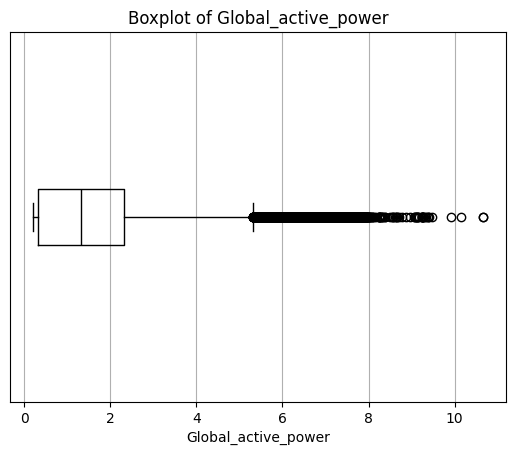

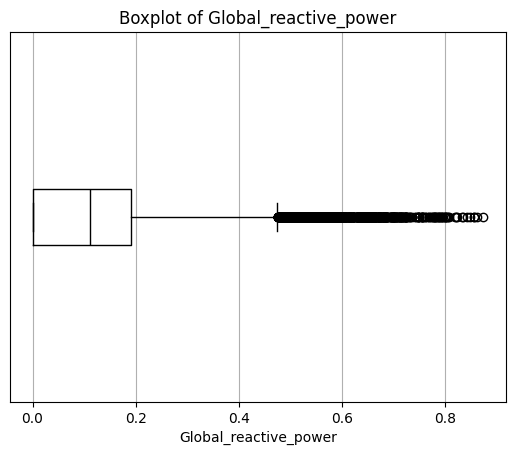

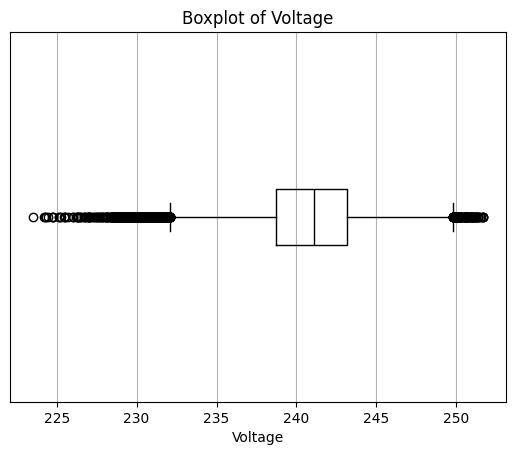

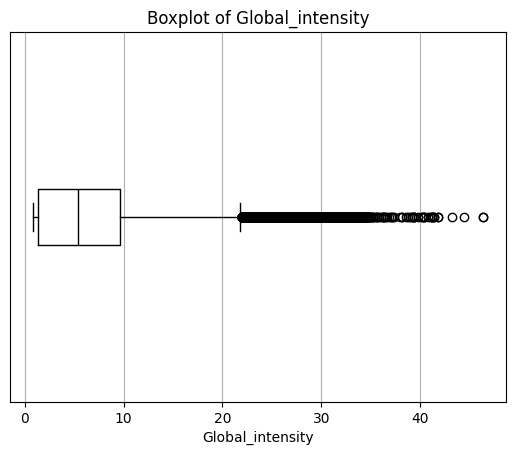

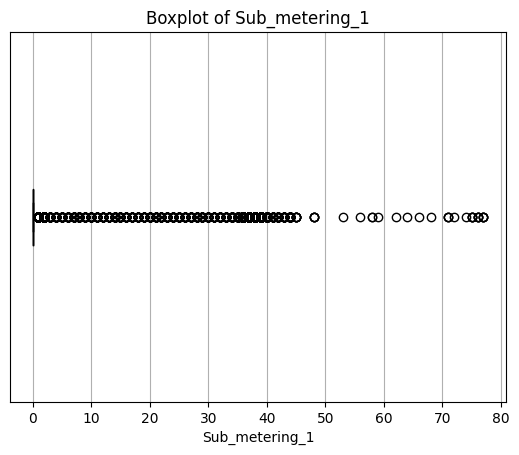

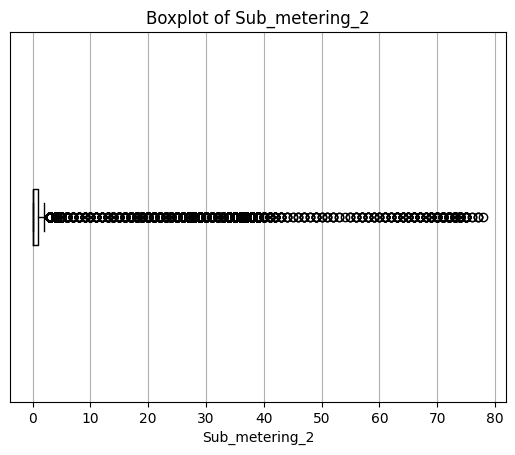

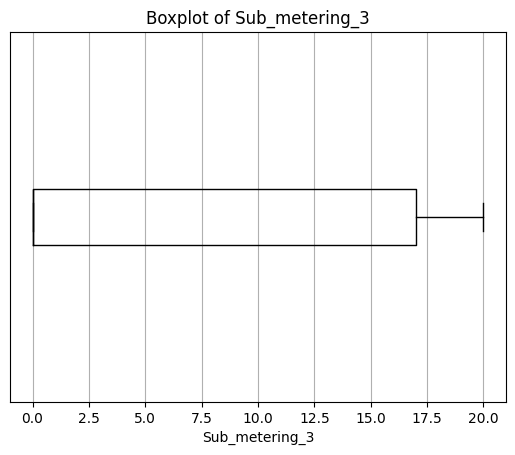

In [4]:
from util import plot_feature_over_time
from util import plot_boxplot_of_feature

plot_boxplot_of_feature(data=raw_data, feature='Global_active_power')
plot_boxplot_of_feature(data=raw_data, feature='Global_reactive_power')
plot_boxplot_of_feature(data=raw_data, feature='Voltage')
plot_boxplot_of_feature(data=raw_data, feature='Global_intensity')
plot_boxplot_of_feature(data=raw_data, feature='Sub_metering_1')
plot_boxplot_of_feature(data=raw_data, feature='Sub_metering_2')
plot_boxplot_of_feature(data=raw_data, feature='Sub_metering_3')

In [5]:
split_index = int(len(raw_data) * 0.7)
raw_train = raw_data[:split_index]
raw_test = raw_data[split_index:]

In [6]:
raw_data.drop(columns=['DateTime']).describe().round(2).to_csv('../csv-descriptions/power-raw-description-numerical.csv')

In [7]:
def preprocess_data(raw_data):
    data = raw_data.copy()
    # Dropped because it is highly correlated
    data.drop(columns=['Global_intensity'], inplace=True)
    data['Hour'] = data['DateTime'].dt.hour
    data['DayOfMonth'] = data['DateTime'].dt.day
    data['DayOfWeek'] = data['DateTime'].dt.dayofweek
    #data['Month'] = data['DateTime'].dt.month
    #data['DayOfYear'] = data['DateTime'].dt.dayofyear
    data['WeekOfYear'] = data['DateTime'].dt.isocalendar().week.astype(int)
    data = convert_feature_into_cyclic(data, 'Hour', 24)
    data = convert_feature_into_cyclic(data, 'DayOfMonth', 31)
    data = convert_feature_into_cyclic(data, 'DayOfWeek', 7)
    #data = convert_feature_into_cyclic(data, 'Month', 12)
    #data = convert_feature_into_cyclic(data, 'DayOfYear', 365)
    data = convert_feature_into_cyclic(data, 'WeekOfYear', 52)
    data.drop(columns=['Hour', 'DayOfMonth', 'DayOfWeek', 'WeekOfYear'], inplace=True)
    numerical_features = list(data.select_dtypes(include=['float32']).columns)
    numerical_features.remove('Global_active_power')
    print(numerical_features)
    for feature in numerical_features:
        data['Log'+feature] = np.log1p(1+data[feature])
        data.drop(columns=[feature], inplace=True)
        # Global_intensity dropped because it is corr
    data.drop(columns=['DateTime'], inplace=True)
    return data

preprocessed_train = preprocess_data(raw_train)
preprocessed_train

['Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


,Global_active_power,HourSin,HourCos,DayOfMonthSin,DayOfMonthCos,DayOfWeekSin,DayOfWeekCos,WeekOfYearSin,WeekOfYearCos,LogGlobal_reactive_power,LogVoltage,LogSub_metering_1,LogSub_metering_2,LogSub_metering_3
0,4.216,-0.965926,-0.258819,-0.101168,-0.994869,-0.974928,-0.222521,-0.239316,0.970942,0.882941,5.467385,0.693147,1.098612,2.944439
1,5.360,-0.965926,-0.258819,-0.101168,-0.994869,-0.974928,-0.222521,-0.239316,0.970942,0.890357,5.462263,0.693147,1.098612,2.890372
2,5.374,-0.965926,-0.258819,-0.101168,-0.994869,-0.974928,-0.222521,-0.239316,0.970942,0.915490,5.460819,0.693147,1.386294,2.944439
3,5.388,-0.965926,-0.258819,-0.101168,-0.994869,-0.974928,-0.222521,-0.239316,0.970942,0.917090,5.462729,0.693147,1.098612,2.944439
4,3.666,-0.965926,-0.258819,-0.101168,-0.994869,-0.974928,-0.222521,-0.239316,0.970942,0.927428,5.470925,0.693147,1.098612,2.944439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83995,0.468,0.258819,0.965926,0.485302,-0.874347,0.781831,0.623490,0.748511,0.663123,0.855266,5.499542,0.693147,1.386294,0.693147
83996,0.402,0.258819,0.965926,0.485302,-0.874347,0.781831,0.623490,0.748511,0.663123,0.811819,5.499379,0.693147,1.098612,0.693147
83997,0.394,0.258819,0.965926,0.485302,-0.874347,0.781831,0.623490,0.748511,0.663123,0.805583,5.494172,0.693147,1.386294,0.693147
83998,0.394,0.258819,0.965926,0.485302,-0.874347,0.781831,0.623490,0.748511,0.663123,0.804689,5.493103,0.693147,1.098612,0.693147


In [8]:
corr = preprocessed_train.corr()
corr[abs(corr) > 0.5]

,Global_active_power,HourSin,HourCos,DayOfMonthSin,DayOfMonthCos,DayOfWeekSin,DayOfWeekCos,WeekOfYearSin,WeekOfYearCos,LogGlobal_reactive_power,LogVoltage,LogSub_metering_1,LogSub_metering_2,LogSub_metering_3
Global_active_power,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.639272,NaN,NaN,0.554426
HourSin,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HourCos,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfMonthSin,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfMonthCos,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekSin,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekCos,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WeekOfYearSin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,-0.89896,NaN,NaN,NaN,NaN,NaN
WeekOfYearCos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.89896,1.00000,NaN,NaN,NaN,NaN,NaN
LogGlobal_reactive_power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


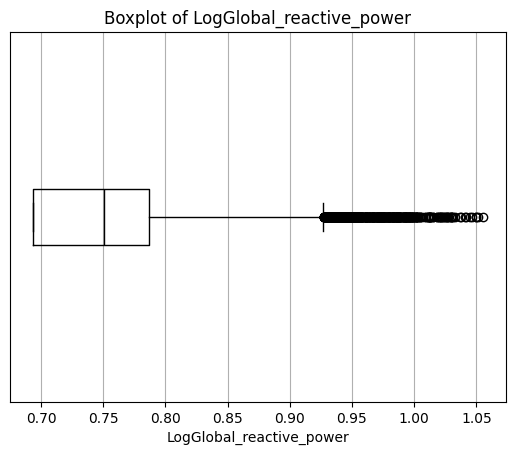

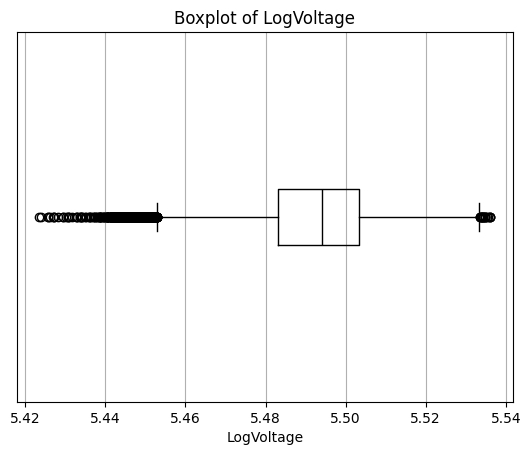

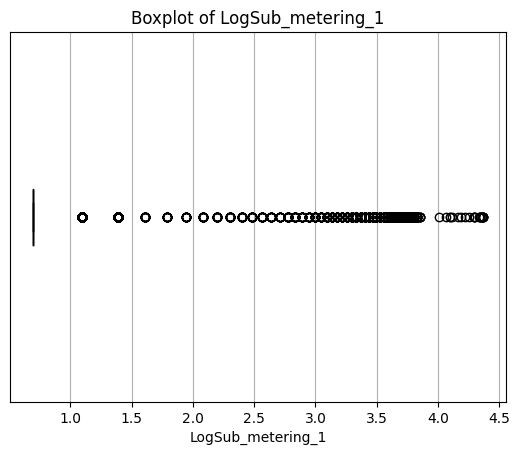

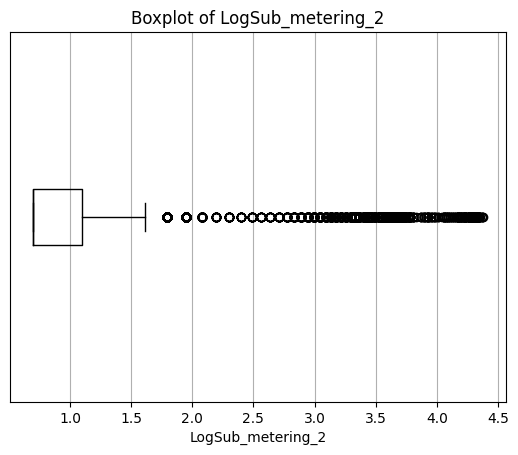

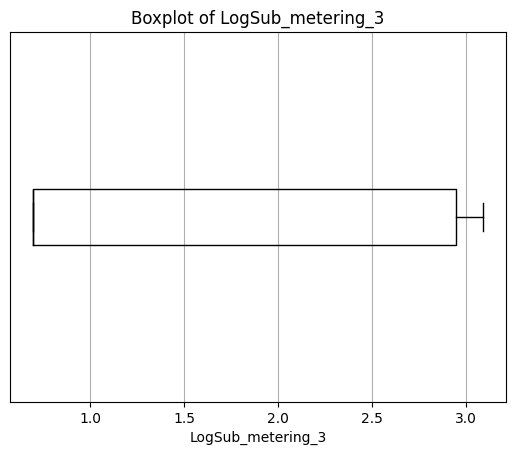

In [14]:
features_to_show = ['LogGlobal_reactive_power', 'LogVoltage', 'LogSub_metering_1', 'LogSub_metering_2', 'LogSub_metering_3']

for feature in features_to_show:
    plot_boxplot_of_feature(data=preprocessed_train, feature=feature)

In [ ]:
from util import training, ElmanRNN

from sklearn.preprocessing import RobustScaler

elman_model_h32 = ElmanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=32, output_size=1, dropout=0.2)

power_elman_h32_results = training(model=elman_model_h32,
                             data=preprocessed_train,
                             batch_size=128,
                             optimizer_learning_rate=0.001,
                             optimizer_weight_decay=1e-4,
                             target_feature_name='Global_active_power',
                             model_name='Power Elman (hidden size 32)',
                             splits=4,
                             patience=20,
                             scaler_X=RobustScaler(),
                             num_epochs=100)


"from util import training, ElmanRNN\n\nfrom sklearn.preprocessing import RobustScaler\n\nelman_model_h32 = ElmanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=32, output_size=1, dropout=0.2)\n\npower_elman_h32_results = training(model=elman_model_h32,\n                             data=preprocessed_train,\n                             batch_size=128,\n                             optimizer_learning_rate=0.001,\n                             optimizer_weight_decay=1e-4,\n                             target_feature_name='Global_active_power',\n                             model_name='Power Elman (hidden size 32)',\n                             splits=4,\n                             patience=20,\n                             scaler_X=RobustScaler(),\n                             num_epochs=100)\n"

In [16]:
import pickle

pickle.dump(power_elman_h32_results, open('../pickles/power_elman_h32_results.pkl', 'wb'))

NameError: name 'power_elman_h32_results' is not defined

In [19]:
power_elman_h32_results = pickle.load(open('../pickles/power_elman_h32_results.pkl', 'rb'))

(83994, 13)
(83994,)
(83931, 64, 13)
(83931,)
Train indices from 0 to 16786 and validation indices from 16787 to 33572
Epoch [1/100], Loss: 3.7002, Validation Loss: 1.6979, Squareroot of Validation Loss: 1.3030
Epoch [2/100], Loss: 1.7394, Validation Loss: 1.1681, Squareroot of Validation Loss: 1.0808
Epoch [3/100], Loss: 1.3693, Validation Loss: 1.0525, Squareroot of Validation Loss: 1.0259
Epoch [4/100], Loss: 1.1809, Validation Loss: 0.9987, Squareroot of Validation Loss: 0.9994
Epoch [5/100], Loss: 1.0689, Validation Loss: 0.9519, Squareroot of Validation Loss: 0.9757
Epoch [6/100], Loss: 0.9813, Validation Loss: 0.9520, Squareroot of Validation Loss: 0.9757
Epoch [7/100], Loss: 0.9283, Validation Loss: 0.9981, Squareroot of Validation Loss: 0.9991
Epoch [8/100], Loss: 0.8941, Validation Loss: 1.0379, Squareroot of Validation Loss: 1.0188
Epoch [9/100], Loss: 0.8632, Validation Loss: 1.0549, Squareroot of Validation Loss: 1.0271
Epoch [10/100], Loss: 0.8423, Validation Loss: 1.0301

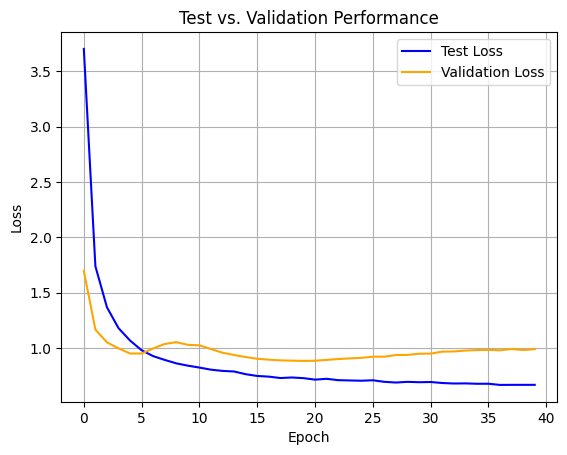

Train indices from 0 to 33572 and validation indices from 33573 to 50358
Epoch [1/100], Loss: 0.8773, Validation Loss: 0.9784, Squareroot of Validation Loss: 0.9891
Epoch [2/100], Loss: 0.8444, Validation Loss: 0.9357, Squareroot of Validation Loss: 0.9673
Epoch [3/100], Loss: 0.8037, Validation Loss: 0.7050, Squareroot of Validation Loss: 0.8396
Epoch [4/100], Loss: 0.7893, Validation Loss: 0.6457, Squareroot of Validation Loss: 0.8035
Epoch [5/100], Loss: 0.7823, Validation Loss: 0.6619, Squareroot of Validation Loss: 0.8136
Epoch [6/100], Loss: 0.7718, Validation Loss: 0.6679, Squareroot of Validation Loss: 0.8173
Epoch [7/100], Loss: 0.7749, Validation Loss: 0.6765, Squareroot of Validation Loss: 0.8225
Epoch [8/100], Loss: 0.7679, Validation Loss: 0.6895, Squareroot of Validation Loss: 0.8304
Epoch [9/100], Loss: 0.7657, Validation Loss: 0.6908, Squareroot of Validation Loss: 0.8311
Epoch [10/100], Loss: 0.7578, Validation Loss: 0.6897, Squareroot of Validation Loss: 0.8305
Epoch 

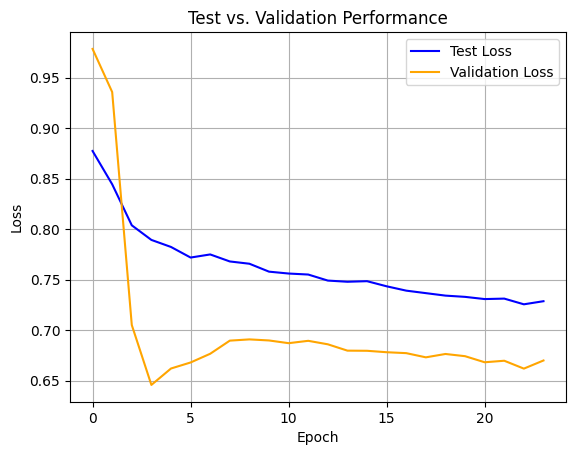

Train indices from 0 to 50358 and validation indices from 50359 to 67144
Epoch [1/100], Loss: 0.6953, Validation Loss: 0.6081, Squareroot of Validation Loss: 0.7798
Epoch [2/100], Loss: 0.6802, Validation Loss: 0.5865, Squareroot of Validation Loss: 0.7658
Epoch [3/100], Loss: 0.6731, Validation Loss: 0.5824, Squareroot of Validation Loss: 0.7632
Epoch [4/100], Loss: 0.6717, Validation Loss: 0.5798, Squareroot of Validation Loss: 0.7615
Epoch [5/100], Loss: 0.6722, Validation Loss: 0.5816, Squareroot of Validation Loss: 0.7626
Epoch [6/100], Loss: 0.6695, Validation Loss: 0.5803, Squareroot of Validation Loss: 0.7618
Epoch [7/100], Loss: 0.6634, Validation Loss: 0.5766, Squareroot of Validation Loss: 0.7594
Epoch [8/100], Loss: 0.6664, Validation Loss: 0.5760, Squareroot of Validation Loss: 0.7590
Epoch [9/100], Loss: 0.6670, Validation Loss: 0.5739, Squareroot of Validation Loss: 0.7576
Epoch [10/100], Loss: 0.6644, Validation Loss: 0.5766, Squareroot of Validation Loss: 0.7593
Epoch 

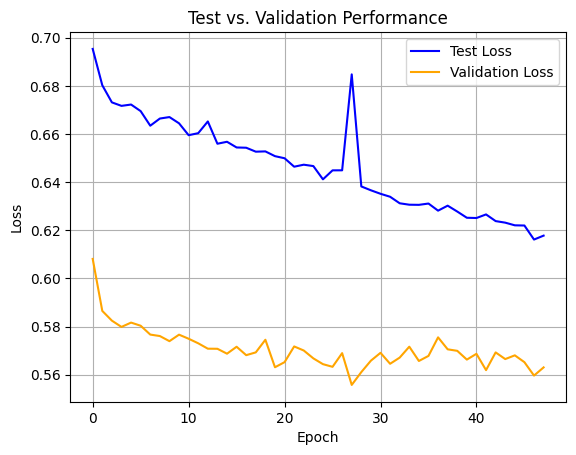

Train indices from 0 to 67144 and validation indices from 67145 to 83930
Epoch [1/100], Loss: 0.6110, Validation Loss: 1.0697, Squareroot of Validation Loss: 1.0343
Epoch [2/100], Loss: 0.6047, Validation Loss: 1.1067, Squareroot of Validation Loss: 1.0520
Epoch [3/100], Loss: 0.6073, Validation Loss: 1.1009, Squareroot of Validation Loss: 1.0492
Epoch [4/100], Loss: 0.6042, Validation Loss: 1.1181, Squareroot of Validation Loss: 1.0574
Epoch [5/100], Loss: 0.6032, Validation Loss: 1.1389, Squareroot of Validation Loss: 1.0672
Epoch [6/100], Loss: 0.6014, Validation Loss: 1.1241, Squareroot of Validation Loss: 1.0602
Epoch [7/100], Loss: 0.6023, Validation Loss: 1.1363, Squareroot of Validation Loss: 1.0660
Epoch [8/100], Loss: 0.5987, Validation Loss: 1.1332, Squareroot of Validation Loss: 1.0645
Epoch [9/100], Loss: 0.5976, Validation Loss: 1.1464, Squareroot of Validation Loss: 1.0707
Epoch [10/100], Loss: 0.5981, Validation Loss: 1.1603, Squareroot of Validation Loss: 1.0772
Epoch 

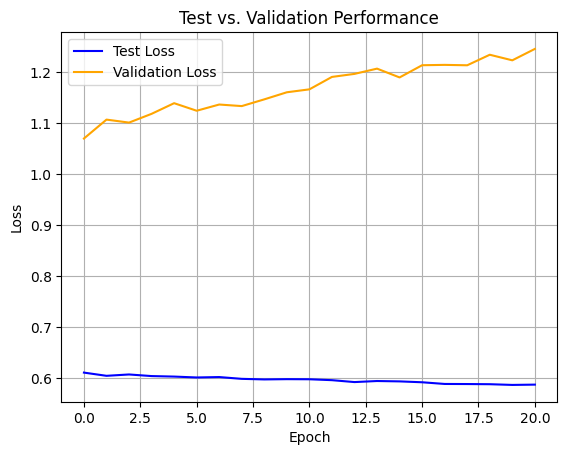

In [17]:
from util import training, ElmanRNN

from sklearn.preprocessing import RobustScaler

jordan_model_h32 = JordanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=32, output_size=1, state_size=32, dropout=0.2)

power_jordan_h32_results = training(model=jordan_model_h32,
                             data=preprocessed_train,
                             batch_size=128,
                             optimizer_learning_rate=0.001,
                             optimizer_weight_decay=1e-4,
                             target_feature_name='Global_active_power',
                             model_name='Power Jordan (hidden size 32)',
                             splits=4,
                             patience=20,
                             scaler_X=RobustScaler(),
                             num_epochs=100)


In [18]:
pickle.dump(power_jordan_h32_results, open('../pickles/power_jordan_h32_results.pkl', 'wb'))

(83994, 13)
(83994,)
(83931, 64, 13)
(83931,)
Train indices from 0 to 16786 and validation indices from 16787 to 33572
Epoch [1/100], Loss: 2.8328, Validation Loss: 1.2247, Squareroot of Validation Loss: 1.1067
Epoch [2/100], Loss: 1.5627, Validation Loss: 1.1016, Squareroot of Validation Loss: 1.0496
Epoch [3/100], Loss: 1.1675, Validation Loss: 0.9507, Squareroot of Validation Loss: 0.9751
Epoch [4/100], Loss: 1.1958, Validation Loss: 0.9564, Squareroot of Validation Loss: 0.9779
Epoch [5/100], Loss: 1.0029, Validation Loss: 1.0352, Squareroot of Validation Loss: 1.0174
Epoch [6/100], Loss: 0.9483, Validation Loss: 1.1611, Squareroot of Validation Loss: 1.0775
Epoch [7/100], Loss: 0.9193, Validation Loss: 1.0152, Squareroot of Validation Loss: 1.0075
Epoch [8/100], Loss: 0.8890, Validation Loss: 1.1824, Squareroot of Validation Loss: 1.0874
Epoch [9/100], Loss: 0.8105, Validation Loss: 1.2122, Squareroot of Validation Loss: 1.1010
Epoch [10/100], Loss: 0.7680, Validation Loss: 1.2239

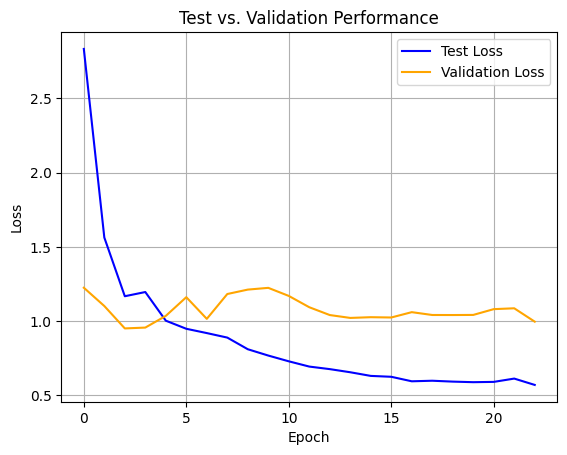

Train indices from 0 to 33572 and validation indices from 33573 to 50358
Epoch [1/100], Loss: 0.9623, Validation Loss: 0.7947, Squareroot of Validation Loss: 0.8915
Epoch [2/100], Loss: 0.8736, Validation Loss: 0.6110, Squareroot of Validation Loss: 0.7816
Epoch [3/100], Loss: 0.8316, Validation Loss: 0.6385, Squareroot of Validation Loss: 0.7991
Epoch [4/100], Loss: 0.7770, Validation Loss: 0.6997, Squareroot of Validation Loss: 0.8365
Epoch [5/100], Loss: 0.7584, Validation Loss: 0.8169, Squareroot of Validation Loss: 0.9038
Epoch [6/100], Loss: 0.7503, Validation Loss: 0.7460, Squareroot of Validation Loss: 0.8637
Epoch [7/100], Loss: 0.7048, Validation Loss: 0.7780, Squareroot of Validation Loss: 0.8821
Epoch [8/100], Loss: 0.6730, Validation Loss: 0.7941, Squareroot of Validation Loss: 0.8911
Epoch [9/100], Loss: 0.6342, Validation Loss: 0.8937, Squareroot of Validation Loss: 0.9453
Epoch [10/100], Loss: 0.6211, Validation Loss: 0.8472, Squareroot of Validation Loss: 0.9205
Epoch 

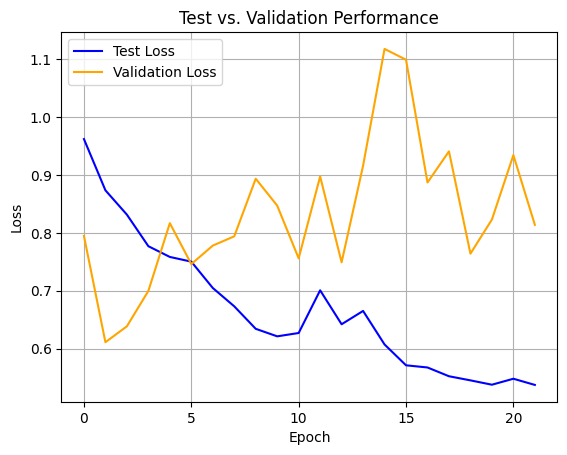

Train indices from 0 to 50358 and validation indices from 50359 to 67144
Epoch [1/100], Loss: 0.5836, Validation Loss: 0.8976, Squareroot of Validation Loss: 0.9474
Epoch [2/100], Loss: 0.5583, Validation Loss: 0.7995, Squareroot of Validation Loss: 0.8941
Epoch [3/100], Loss: 0.5593, Validation Loss: 0.9150, Squareroot of Validation Loss: 0.9565
Epoch [4/100], Loss: 0.5510, Validation Loss: 0.6546, Squareroot of Validation Loss: 0.8091
Epoch [5/100], Loss: 0.5376, Validation Loss: 0.6429, Squareroot of Validation Loss: 0.8018
Epoch [6/100], Loss: 0.5345, Validation Loss: 0.6405, Squareroot of Validation Loss: 0.8003
Epoch [7/100], Loss: 0.5352, Validation Loss: 0.5844, Squareroot of Validation Loss: 0.7645
Epoch [8/100], Loss: 0.5269, Validation Loss: 0.6182, Squareroot of Validation Loss: 0.7863
Epoch [9/100], Loss: 0.4920, Validation Loss: 0.6254, Squareroot of Validation Loss: 0.7908
Epoch [10/100], Loss: 0.5303, Validation Loss: 0.6207, Squareroot of Validation Loss: 0.7878
Epoch 

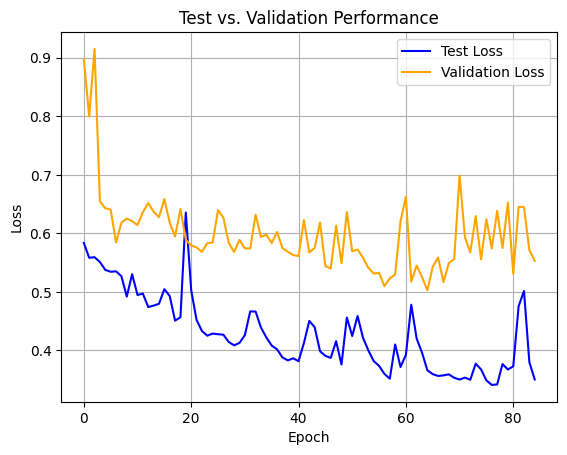

Train indices from 0 to 67144 and validation indices from 67145 to 83930
Epoch [1/100], Loss: 0.4426, Validation Loss: 0.7441, Squareroot of Validation Loss: 0.8626
Epoch [2/100], Loss: 0.4408, Validation Loss: 0.7685, Squareroot of Validation Loss: 0.8766
Epoch [3/100], Loss: 0.4335, Validation Loss: 0.7969, Squareroot of Validation Loss: 0.8927
Epoch [4/100], Loss: 0.4126, Validation Loss: 0.8103, Squareroot of Validation Loss: 0.9002
Epoch [5/100], Loss: 0.4367, Validation Loss: 0.7461, Squareroot of Validation Loss: 0.8638
Epoch [6/100], Loss: 0.4032, Validation Loss: 0.7682, Squareroot of Validation Loss: 0.8765
Epoch [7/100], Loss: 0.4376, Validation Loss: 0.8032, Squareroot of Validation Loss: 0.8962
Epoch [8/100], Loss: 0.3916, Validation Loss: 0.7542, Squareroot of Validation Loss: 0.8685
Epoch [9/100], Loss: 0.3926, Validation Loss: 0.7483, Squareroot of Validation Loss: 0.8651
Epoch [10/100], Loss: 0.3862, Validation Loss: 0.7561, Squareroot of Validation Loss: 0.8696
Epoch 

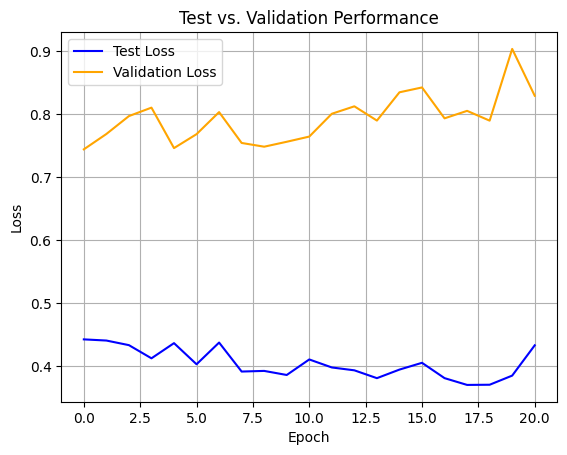

In [9]:
from util import MultiRecurrentNN

from util import training, ElmanRNN

from sklearn.preprocessing import RobustScaler

multirnn_model_h32 = MultiRecurrentNN(input_size=preprocessed_train.shape[1]-1, hidden_size=32, output_size=1, memory_config=[4,4,4],dropout=0.2)

power_multirnn_h32_results = training(model=multirnn_model_h32,
                             data=preprocessed_train,
                             batch_size=128,
                             optimizer_learning_rate=0.001,
                             optimizer_weight_decay=1e-4,
                             target_feature_name='Global_active_power',
                             model_name='Power MultiRNN (hidden size 32)',
                             splits=4,
                             patience=20,
                             scaler_X=RobustScaler(),
                             num_epochs=100)


In [9]:
import pickle

In [ ]:

pickle.dump(power_multirnn_h32_results, open('../pickles/power_multirnn_h32_results.pkl', 'wb'))

In [10]:
power_jordan_h32_results = pickle.load(open('../pickles/power_jordan_h32_results.pkl', 'rb'))
power_multirnn_h32_results = pickle.load(open('../pickles/power_multirnn_h32_results.pkl', 'rb'))
power_elman_h32_results = pickle.load(open('../pickles/power_elman_h32_results.pkl', 'rb')) 

['Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


/home/christopher/Git/Machine-Learning-Assignment-3/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


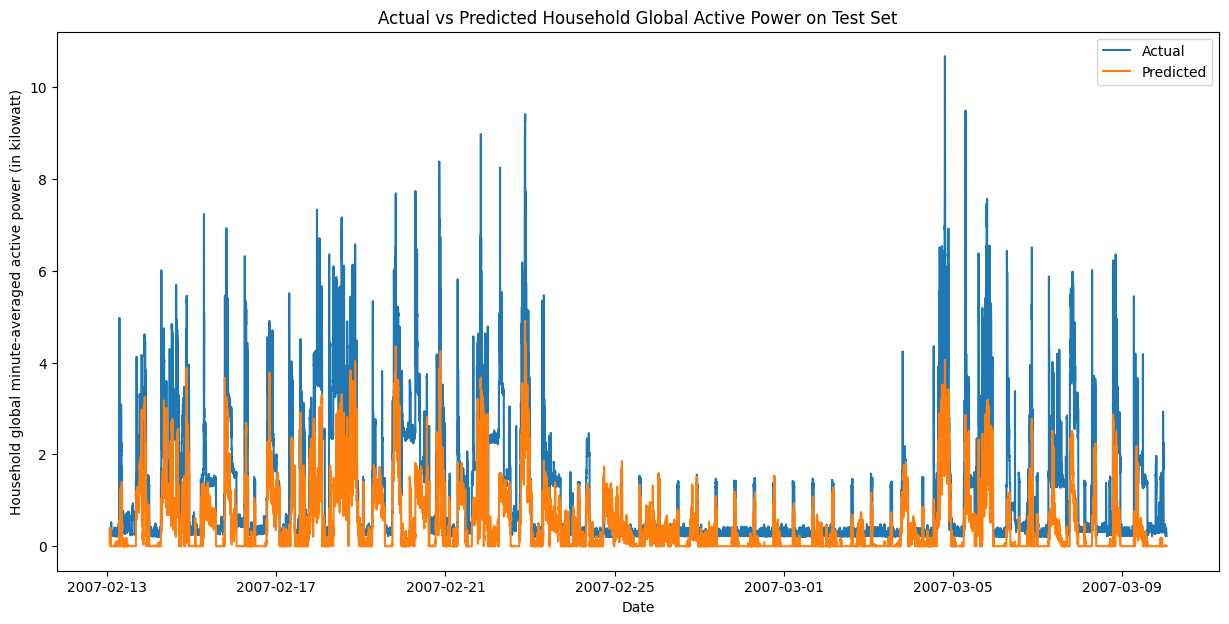

/home/christopher/Git/Machine-Learning-Assignment-3/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


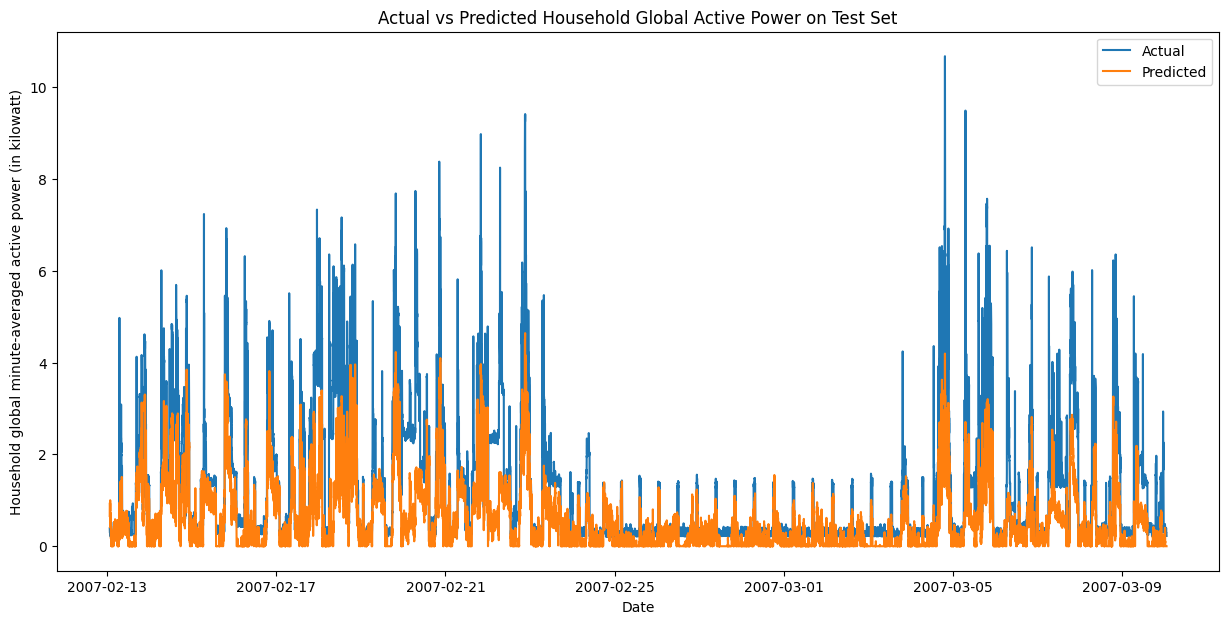

In [13]:
from util import get_predictions
processed_test = preprocess_data(raw_test)
r1 = get_predictions(raw_test=raw_test, 
                     preprocessed_test=processed_test, 
                     results=power_jordan_h32_results, 
                     model_name='JordanRNN H32 Power',
                     xlabel='Date',
                     ylabel='Household global minute-averaged active power (in kilowatt)',
                     title='Actual vs Predicted Household Global Active Power on Test Set',
                     target_feature_name='Global_active_power',
                     save_path='../images/power-jordan-h32-actual-vs-predicted.pdf',
                     show_plot=True,
                     zero_values=True)
r2 = get_predictions(raw_test=raw_test, 
                     preprocessed_test=processed_test, 
                     results=power_elman_h32_results, 
                     model_name='ElmanRNN H32 Power',
                     xlabel='Date',
                     ylabel='Household global minute-averaged active power (in kilowatt)',
                     target_feature_name='Global_active_power',
                     title='Actual vs Predicted Household Global Active Power on Test Set',
                     save_path='../images/power-elman-h32-actual-vs-predicted.pdf',
                     show_plot=True,
                     zero_values=True)

['Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


/home/christopher/Git/Machine-Learning-Assignment-3/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


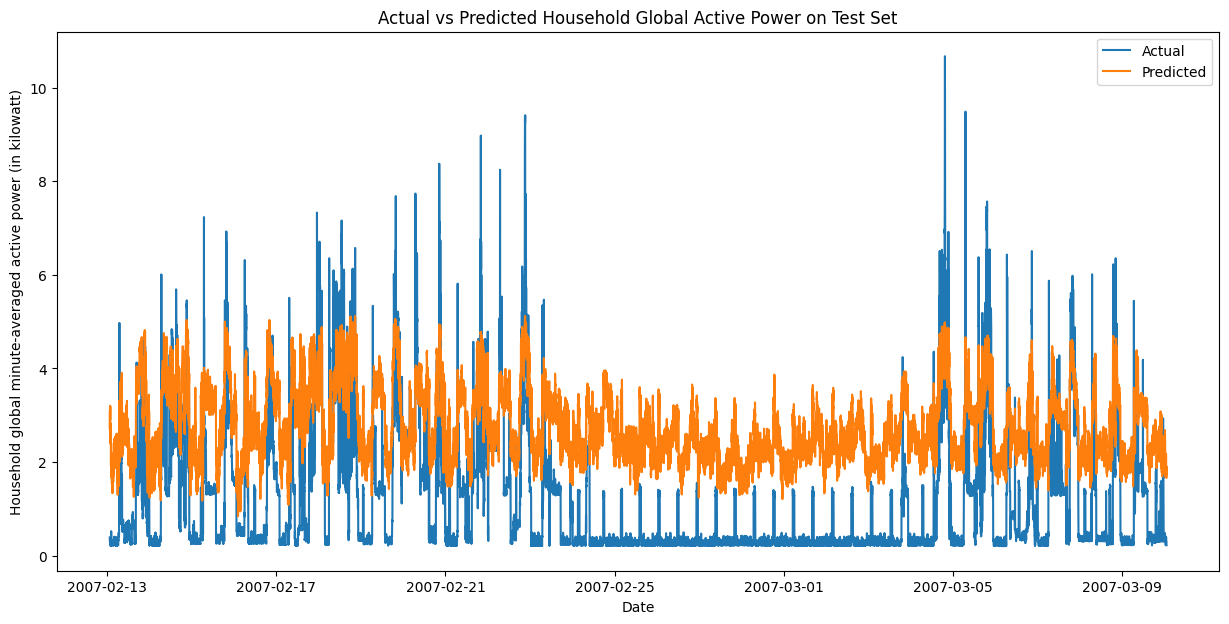

In [12]:
from util import get_predictions
processed_test = preprocess_data(raw_test)
r3 = get_predictions(raw_test=raw_test, 
                     preprocessed_test=processed_test, 
                     results=power_multirnn_h32_results, 
                     model_name='MultiRNN H32 Power',
                     xlabel='Date',
                     ylabel='Household global minute-averaged active power (in kilowatt)',
                     title='Actual vs Predicted Household Global Active Power on Test Set',
                     target_feature_name='Global_active_power',
                     save_path='../images/power-multirnn-h32-actual-vs-predicted.pdf',
                     show_plot=True)

In [15]:
results = pd.concat([r1, r2, r3])
results.round(2).to_csv('../csv-descriptions/power-rnn-results-raw.csv', index=True)
results.round(2)

,Mean,Std. Dev.,Min,25%,Median,75%,Max
JordanRNN H32 Power,0.71,0.74,0.0,0.24,0.37,0.92,6.71
ElmanRNN H32 Power,0.60,0.70,0.0,0.20,0.31,0.76,6.84
MultiRNN H32 Power,1.68,0.63,0.0,1.42,1.78,2.07,5.70
